# Will's cone detection notebook

## Purpose

I'm not very good at java tbh, so I'll do my code things here.

In [164]:
from functools import reduce
import cv2
import numpy as np
import matplotlib.pyplot as plt
from num2words import num2words

# grab relative path for loading images
import os
notebook_path = os.path.abspath("Notebook.ipynb")

def compose(*f_arg_pairs):
    def cr(*fs):
        pair = fs[0]
        if len(fs) == 1:
            return lambda x:pair[0](x,*pair[1])
        return lambda x:pair[0](cr(*fs[1:])(x),*pair[1])
    return cr(*reversed(f_arg_pairs))

def compose_gen(*f_arg_pairs):
    def cr(arg):
        pairs = [arg]
        for f_arg in f_arg_pairs:
            pairs.append(f_arg[0](pairs[-1], *f_arg[1]))
        return pairs
    return cr

digitalsum = compose(
    (int,()),
    (str,()),
    (list,()),
    (lambda x: (int(n) for n in x),()),
    (sum, ()),
)

# print(digitalsum(314159265358979323))


def add_image(*dispImage):
    fig = plt.figure(figsize=(6*len(dispImage),8))
    for index, img in enumerate(dispImage):
        fig.add_subplot(1, len(dispImage), index+1)
        # showing image
        plt.imshow(img)
        plt.axis('off')
        plt.title(num2words(index+1,True,to="ordinal").capitalize())


## Image processing functions

In [165]:
def flood_from_pix(floodImg: np.ndarray, pixel: tuple = ()):
    h, w = floodImg.shape[:2]
    if not pixel: pixel = (w//2, h//2)
    mask = np.zeros((h+2,w+2), np.uint8)
    flat = floodImg.astype("uint8")
    cv2.floodFill(flat, mask, pixel, 255)
    return cv2.threshold(flat, 254, 255, cv2.THRESH_BINARY)[1]

def resize_image(dimImage: np.ndarray, newsize: tuple = ()):
    print(dims:=dimImage.shape)
    if newsize:
        rowedge = (dims[0]-newsize[0])//2
        coledge = (dims[1]-newsize[1])//2
        return dimImage[rowedge:dims[0]-rowedge,coledge:dims[1]-coledge]

    return dimImage

def tri_stack(stackImg: np.ndarray):
    return np.dstack([stackImg,stackImg,stackImg])

def extract_channel(extrImg: np.ndarray, channel: int = 0):
    return tri_stack(extrImg[:,:,channel])

def point(pointImg: np.ndarray, xy: tuple, clr: tuple):
    return cv2.circle(pointImg, xy, radius=5, color=clr, thickness=-1)

## Shape Pipeline

This pipeline takes a cone with a shape on it, and returns a mask over the shape.

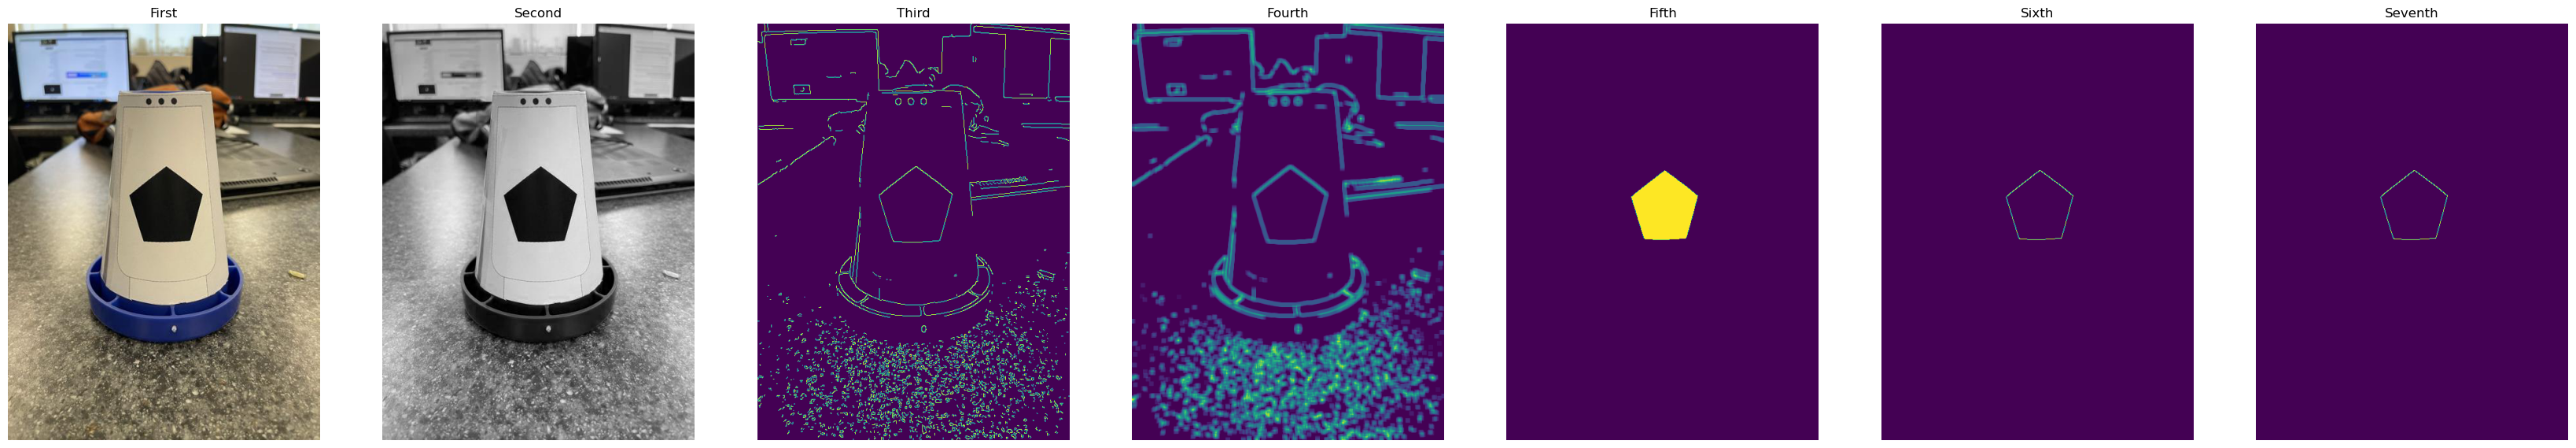

In [171]:
from pickle import dump

color_pipeline = lambda img, seed: compose_gen(
        (extract_channel, (0,)),
        # 200 is min, 250 is max. If theres too much bg noise, turn up 200. If the shape gets cut, turn up 250.
        (cv2.Canny, (200, 250)),
        (cv2.blur, ((7, 7),)),
        (flood_from_pix, (seed,)),
        (cv2.Canny, (200, 250)),
        # (point, (seed, (255,0,0))),
        # (tri_stack, ()),
        (np.ndarray.astype,("uint8",)),
    )(img)

image = cv2.imread("Images/Shapes/Downscaled/pentagon_downscaled_cone.jpg")
# webcam = cv2.VideoCapture(0)
# image = webcam.read()[1]
# webcam.release()

prep_pipeline = compose(
    (cv2.flip, (1,)),
    (cv2.cvtColor, (cv2.COLOR_RGB2BGR,)),
    # (resize_image, ((480,360),)),
)

image = prep_pipeline(image)

cnvimage = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
cnvimages = color_pipeline(image,(250,245))
# cnvimage = cv2.cvtColor(cnvimage, cv2.COLOR_HSV2RGB)
add_image(*cnvimages)
# cnvimage = cv2.cvtColor(cnvimage, cv2.COLOR_RGB2GRAY)

# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# cv2.imwrite("Images/Shapes V2/Normal/Pentagon.png",image)
# cv2.imwrite("Images/Shapes V2/Processed/Pentagon.png",cnvimage)

dump(cnvimages[-1], open("temp/cnvimage",'wb+'))

### Grab edges

Take the edges, find the contours, and then approximate as a polygon.

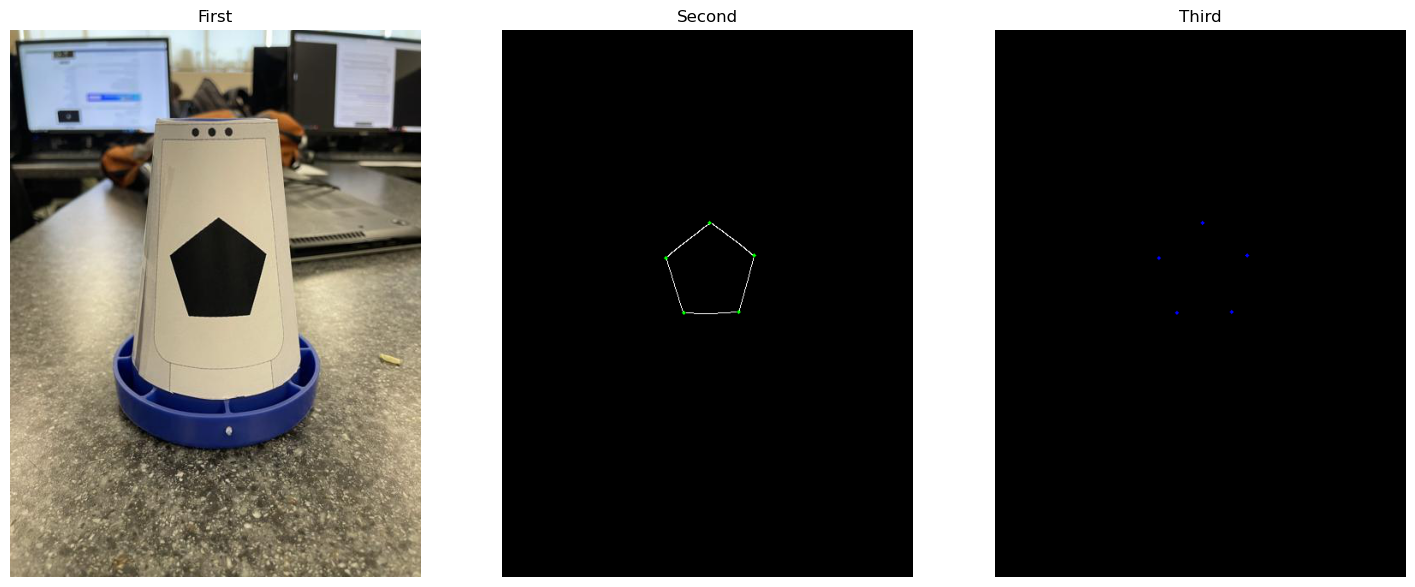

In [179]:
from pickle import load

cnvimage = load(open("temp/cnvimage",'rb'))

def count_poly_seed(seed: tuple):
    contours, _ = cv2.findContours(color_pipeline(image,seed)[-1], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return cv2.approxPolyDP(contours[0],10,True)

poly = count_poly_seed((245,250))

cnv_draw = np.zeros(cnvimage.shape,dtype=np.uint8)
cnv_draw = tri_stack(cnv_draw)
cnv_draw = cv2.polylines(cnv_draw,poly,True,(0,0,255),3)
# cnv_draw = cv2.drawContours(cnv_draw,poly,-1,(0,0,255),3)

cnvimage = tri_stack(cnvimage)
cnvimage = cv2.drawContours(cnvimage,poly,-1,(0,255,0),3)

add_image(image, cnvimage, cnv_draw)

## Get middle pixel
This will get the middle pixel location, from there we can do an additional color analysis

In [169]:
print(*[sum(poly[:,:,x])[0]//len(poly) for x in (0,1)])

243 283
